# Mañcheno (2022) and [Mendez and Losada (2004)](https://www.sciencedirect.com/science/article/abs/pii/S0378383903001182)

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [118]:
# numerical model parameters
dx = 1e-3

# empirical constants
γ = 0.6  # Mendez and Losada (2004)
B = 1    # Mendez and Losada (2004)

# climate parameters (need to review freq. and wave number)
h = np.arange(2, 0.5, -dx)  # bathymetry
Tp = 3.5                    # peak wave period (s)
fp = 1 / Tp                 # peak frequency (s-1)
L = 60                      # TODO: min wind wavelength: https://en.wikipedia.org/wiki/Wind_wave
kp = 1 / L                  # TODO: wave number associated to peak wave period (m-1)
cdw = 0.4                   # drag coefficient
hm0 = 0.6                   # significant wave height (m)
hrms = 0.12                  # TODO: rms wave heights (m) made-up based on Mendez and Losada (2004)

# vegetation parameters (salt marshes 3.2.1.1) S1
hv = 0.2   # average vegetation height (m)
nv = 944   # plants per m2
bv = 0.030 # mean stem width (m)

## Plot the dissipation functions over the bathymetry

In [51]:
# dissipation functions
def breaking_dissipation(h, fp, hrms, B=1, γ=0.6):
    
    g = 9.81
    rho = 997  # density of water (kg/m3)
    
    eb = (3 * np.pi / 16)
    eb *= (rho * g)
    eb *= (B**3 * fp) / (γ**4 * h**5)
    eb *= Hrms**7
    
    return eb

def veg_dissipation(hv, h, cdw, bv, nv, kp, sigma_p, hrms):
    """Mendez and Losada (2004).
    
    Assuming negligible plant motion, that the wave-driven flow can be defined
    using linear wave theory, and that waves are irregular and follow a Rayleigh
    distribution.
    
    Unsure about sigma_p.
    
    Parameters:
    ----------
    hv : float
        Vegetation height (m)
    """
    g = 9.81
    rho = 997  # density of water (kg/m3)
    
    ev = 1 / (2 * np.sqrt(np.pi))
    ev *= rho * cdw * bv * nv
    ev *= ((kp * g) / (2 * sigma_p))**3
    
    nom = np.sinh(kp * hv)**3 + (3 * np.sinh(kp * hv))
    denom = 3 * kp * np.cosh(kp * h)
    
    ev *= (nom / denom) * hrms**3
    
    return ev

Vegetation height 0.2


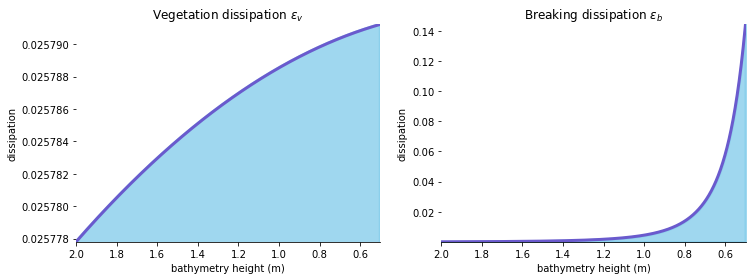

In [93]:
# calculate dissipation rates
hv = 0.2
veg_dissip = []
breaking_dissip = []

for i, ih in enumerate(h):
    breaking_dissip.append(breaking_dissipation(ih, fp, hrms))
    veg_dissip.append(veg_dissipation(hv, ih, cdw, bv, nv, kp, fp, hrms))
                      
                      
# plot the results
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(h, veg_dissip, linewidth=3, color='slateblue')
axs[1].plot(h, breaking_dissip, linewidth=3, color='slateblue')
axs[0].fill_between(h, veg_dissip, linewidth=3, color='skyblue', alpha=0.8)
axs[1].fill_between(h, breaking_dissip, linewidth=3, color='skyblue', alpha=0.8)

axs[0].set_ylim([min(veg_dissip), max(veg_dissip)])
axs[1].set_ylim([min(breaking_dissip), max(breaking_dissip)])

axs[0].set_title(r'Vegetation dissipation $\epsilon_v$')
axs[1].set_title(r'Breaking dissipation $\epsilon_b$')

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xlabel('bathymetry height (m)')
    ax.set_ylabel('dissipation')
    ax.set_xlim([2, 0.5])
    
print(f"Vegetation height {hv}")

## Wave energy balance equation

In [116]:
# forward Euler (numerically unstable)
def forward_euler(ecg, dx, hv, h, cdw, bv, nv, kp, hrms, fp):
    ev = veg_dissipation(hv, h, cdw, bv, nv, kp, fp, hrms)
    eb = breaking_dissipation(h, fp, hrms)
    return ecg - dx * (eb + ev)

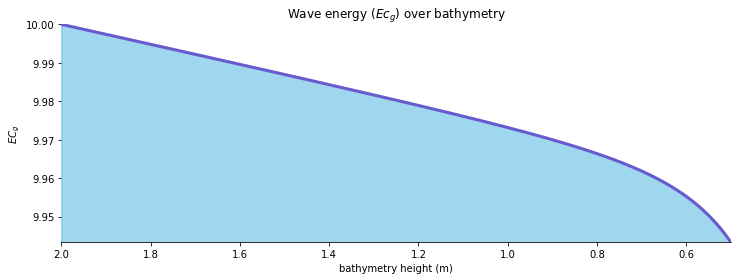

In [131]:
ecg = 10
hv = 0.2
ecgs = []
    
for i, ih in enumerate(h):
    ecgs.append(ecg)
    ecg = forward_euler(ecg, dx, hv, ih, cdw, bv, nv, kp, hrms, fp)
    
# plot the results
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(h, ecgs, linewidth=3, color='slateblue')
ax.fill_between(h, ecgs, linewidth=3, color='skyblue', alpha=0.8)

ax.set_ylim([min(ecgs), max(ecgs)])
ax.set_title(r'Wave energy ($Ec_g$) over bathymetry')


ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('bathymetry height (m)')
ax.set_ylabel(r'$EC_g$')
ax.set_xlim([2, 0.5]);